In [ ]:
# DACON 병변검출 AI 경진대회에 공유된 코드를 수정했습니다.
# https://dacon.io/competitions/official/235855/codeshare/3743?page=1&dtype=recent

# Prepare Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

import seaborn as sns
from pathlib import Path
import scipy 
from joblib import Parallel , delayed

In [ ]:
# Colab 환경에서 실행할 시 '/content'에 train 및 test 폴더를 압축해제합니다.
# data.zip 은 https://dacon.io/competitions/official/235855/data 에서 다운로드 받을 수 있습니다.
!unzip -uq '/content/drive/MyDrive/Detection_of_lesions/data.zip' -d '/content'

In [ ]:
# test 폴더 내의 파일만 필요하므로 glob 함수를 이용해 경로를 리스트에 저장합니다.
test_files = sorted(glob('/content/test/*'))

In [ ]:
# 테스트 데이터가 잘 로드되었는지 확인합니다.
if len(test_files) == 20874:
  print('데이터를 정상적으로 불러왔습니다.')
else:
  print('데이터 길이에 문제가 있습니다.')

데이터를 정상적으로 불러왔습니다.


In [ ]:
IMG_SIZE = 256
base_path = Path('/content')
test_path = list((base_path / 'test').glob('test*'))

In [ ]:
label_info = pd.read_csv((base_path /'class_id_info.csv'))
categories = {i[0]:i[1]-1 for i in label_info.to_numpy()}
label_info

,class,class_id
0,01_ulcer,1
1,02_mass,2
2,04_lymph,3
3,05_bleeding,4


In [ ]:
# json file 을 읽은후 yolo format으로 bbox를 만들고 image를 decoding하여 image를 해당폴더에 생성합니다.

def xyxy2coco(xyxy):
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    return [x1,y1,w,h] 

def xyxy2yolo(xyxy):
    
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    xc = x1 + int(np.round(w/2)) # xmin + width/2
    yc = y1 + int(np.round(h/2)) # ymin + height/2
    return [xc/IMG_SIZE,yc/IMG_SIZE,w/IMG_SIZE,h/IMG_SIZE] 

def scale_bbox(img, xyxy):
    # Get scaling factor
    scale_x = IMG_SIZE/img.shape[1]
    scale_y = IMG_SIZE/img.shape[0]
    
    x1,y1,x2,y2 =xyxy
    x1 = int(np.round(x1*scale_x,4))
    y1 = int(np.round(y1*scale_y, 4))
    x2 = int(np.round(x2*scale_x, 4))
    y2= int(np.round(y2*scale_y, 4))

    return [x1, y1, x2, y2] # xmin, ymin, xmax, ymax

def save_image_label(json_file,mode): 
    with open(json_file,'r') as f: 
        json_file =json.load(f)

    image_id = json_file['file_name'].replace('.json','')
    
    # decode image data
    image = np.frombuffer(base64.b64decode(json_file['imageData']), np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    cv2.imwrite(str(new_image_path / (image_id + '.png')) ,image)
    
    test_size_memo[image_id + '.txt'] = image.shape[0]
    
    # extract bbox
    origin_bbox = []
    if mode == 'train':
        with open(new_label_path / (image_id + '.txt'), 'w') as f:
            for i in json_file['shapes']: 
                bbox = i['points'][0] + i['points'][2]
                origin_bbox.append(bbox)
                bbox = scale_bbox(image,bbox)
                bbox = xyxy2yolo(bbox)
                
                labels = [categories[i['label']]]+bbox
                f.writelines([f'{i} ' for i in labels] + ['\n']) 
    return origin_bbox

In [ ]:
# Test set prepare
import multiprocessing as mp 

# 저장할 파일 경로
save_path = Path('./test_data')
new_image_path = save_path / 'images' # image폴더 
new_label_path = save_path / 'labels' # label폴더

new_image_path.mkdir(parents=True,exist_ok=True)
new_label_path.mkdir(parents=True,exist_ok=True)

# data를 생성하기 위해 mlutiprocessing 적용
test_size_memo = {}
tmp = Parallel(n_jobs=mp.cpu_count(),prefer="threads")(delayed(save_image_label)(str(test_json),'test') for test_json in tqdm(test_path))

100%|██████████| 20874/20874 [02:25<00:00, 143.23it/s]


In [ ]:
# 욜로 다운로드
! git clone https://github.com/ultralytics/yolov5
! pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 10142, done.
remote: Total 10142 (delta 0), reused 0 (delta 0), pack-reused 10142
Receiving objects: 100% (10142/10142), 10.43 MiB | 28.80 MiB/s, done.
Resolving deltas: 100% (7034/7034), done.
     |████████████████████████████████| 596 kB 5.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Get Result

In [ ]:
!python ./yolov5/detect.py --weights /content/drive/MyDrive/best.pt --img 256 --source ./test_data/images --save-conf --save-txt

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
image 15878/20874 /content/test_data/images/test_215877.png: 256x256 1 04_lymph, Done. (0.035s)
image 15879/20874 /content/test_data/images/test_215878.png: 256x256 1 01_ulcer, Done. (0.034s)
image 15880/20874 /content/test_data/images/test_215879.png: 256x256 1 02_mass, Done. (0.034s)
image 15881/20874 /content/test_data/images/test_215880.png: 256x256 1 01_ulcer, 1 05_bleeding, Done. (0.035s)
image 15882/20874 /content/test_data/images/test_215881.png: 256x256 1 04_lymph, Done. (0.035s)
image 15883/20874 /content/test_data/images/test_215882.png: 256x256 3 04_lymphs, Done. (0.035s)
image 15884/20874 /content/test_data/images/test_215883.png: 256x256 1 05_bleeding, Done. (0.034s)
image 15885/20874 /content/test_data/images/test_215884.png: 256x256 2 01_ulcers, Done. (0.034s)
image 15886/20874 /content/test_data/images/test_215885.png: 256x256 3 04_lymphs, Done. (0.035s)
image 15887/20874 /content/test_data/images/test_215886.png: 256x256 1 05_bleedi

# Convert output

In [ ]:
# convert txt to df
# path example : '/content/yolov5/runs/detect/exp3/labels'

def conv_txt_to_df(path):
    path += ('*.txt' if path[-1] == '/' else '/*.txt')
    test_label_txts = sorted(glob(path))
    result_list = []
    for txt in test_label_txts:
        with open(txt, 'r') as t:
            filename = t.name.split('/')[-1]
            for bbox in t.readlines():
                result_list.append([filename] + bbox.strip().split())
    result_df = pd.DataFrame(result_list, columns = ['file_name', 'class_id', 'x_cent', 'y_cent', 'width', 'height', 'confidence'])
    return result_df

In [ ]:
############## 모델 런 2번이상 했으면 exp -> exp2 등으로 바꿔줘야 합니다 ###################
result_df = conv_txt_to_df('/content/yolov5/runs/detect/exp/labels')
result_df

,file_name,class_id,x_cent,y_cent,width,height,confidence
0,test_200000.txt,3,0.677951,0.626736,0.046875,0.0520833,0.588344
1,test_200001.txt,0,0.804688,0.432292,0.217014,0.225694,0.720208
2,test_200001.txt,0,0.328125,0.690104,0.243056,0.244792,0.779208
3,test_200002.txt,1,0.491319,0.72309,0.208333,0.244792,0.889888
4,test_200003.txt,1,0.8625,0.614062,0.275,0.396875,0.899944
...,...,...,...,...,...,...,...
31752,test_220870.txt,2,0.615625,0.1625,0.0875,0.25625,0.903052
31753,test_220871.txt,3,0.697049,0.323785,0.112847,0.112847,0.700792
31754,test_220872.txt,0,0.694444,0.739583,0.145833,0.170139,0.812092
31755,test_220873.txt,0,0.657118,0.845486,0.293403,0.180556,0.541861


In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31757 entries, 0 to 31756
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   31757 non-null  object
 1   class_id    31757 non-null  object
 2   x_cent      31757 non-null  object
 3   y_cent      31757 non-null  object
 4   width       31757 non-null  object
 5   height      31757 non-null  object
 6   confidence  31757 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [ ]:
def make_size(x):
    return test_size_memo[x]


result_df['size'] = result_df.file_name.apply(make_size)
result_df['x_cent'] = result_df['x_cent'].astype(float) * result_df['size']
result_df['y_cent'] = result_df['y_cent'].astype(float) * result_df['size']
result_df['width'] = result_df['width'].astype(float) * result_df['size']
result_df['height'] = result_df['height'].astype(float) * result_df['size']

result_df = result_df.drop('size', axis = 1)
result_df

,file_name,class_id,x_cent,y_cent,width,height,confidence
0,test_200000.txt,3,390.499776,360.999936,27.000000,29.999981,0.588344
1,test_200001.txt,0,463.500288,249.000192,125.000064,129.999744,0.720208
2,test_200001.txt,0,189.000000,397.499904,140.000256,141.000192,0.779208
3,test_200002.txt,1,282.999744,416.499840,119.999808,141.000192,0.889888
4,test_200003.txt,1,276.000000,196.499840,88.000000,127.000000,0.899944
...,...,...,...,...,...,...,...
31752,test_220870.txt,2,197.000000,52.000000,28.000000,82.000000,0.903052
31753,test_220871.txt,3,401.500224,186.500160,64.999872,64.999872,0.700792
31754,test_220872.txt,0,399.999744,425.999808,83.999808,98.000064,0.812092
31755,test_220873.txt,0,378.499968,486.999936,169.000128,104.000256,0.541861


In [ ]:
result_df.file_name = result_df.file_name.apply(lambda x : x.replace('.txt', '.json'))
result_df.class_id = result_df.class_id.apply(lambda x : int(x) + 1)
result_df.confidence = result_df.confidence.apply(float)

result_df['point1_x'] = result_df.x_cent - (result_df.width / 2)
result_df['point1_y'] = result_df.y_cent - (result_df.height / 2)

result_df['point2_x'] = result_df.x_cent + (result_df.width / 2)
result_df['point2_y'] = result_df.y_cent - (result_df.height / 2)

result_df['point3_x'] = result_df.x_cent + (result_df.width / 2)
result_df['point3_y'] = result_df.y_cent + (result_df.height / 2)

result_df['point4_x'] = result_df.x_cent - (result_df.width / 2)
result_df['point4_y'] = result_df.y_cent + (result_df.height / 2)

result_df = result_df.drop(['x_cent', 'y_cent', 'width', 'height'], axis = 1)
result_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,4,0.588344,376.999776,345.999946,403.999776,345.999946,403.999776,375.999926,376.999776,375.999926
1,test_200001.json,1,0.720208,401.000256,184.000320,526.000320,184.000320,526.000320,314.000064,401.000256,314.000064
2,test_200001.json,1,0.779208,118.999872,326.999808,259.000128,326.999808,259.000128,468.000000,118.999872,468.000000
3,test_200002.json,2,0.889888,222.999840,345.999744,342.999648,345.999744,342.999648,486.999936,222.999840,486.999936
4,test_200003.json,2,0.899944,232.000000,132.999840,320.000000,132.999840,320.000000,259.999840,232.000000,259.999840
...,...,...,...,...,...,...,...,...,...,...,...
31752,test_220870.json,3,0.903052,183.000000,11.000000,211.000000,11.000000,211.000000,93.000000,183.000000,93.000000
31753,test_220871.json,4,0.700792,369.000288,154.000224,434.000160,154.000224,434.000160,219.000096,369.000288,219.000096
31754,test_220872.json,1,0.812092,357.999840,376.999776,441.999648,376.999776,441.999648,474.999840,357.999840,474.999840
31755,test_220873.json,1,0.541861,293.999904,434.999808,463.000032,434.999808,463.000032,539.000064,293.999904,539.000064


In [ ]:
result_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,test_200000.json,4,0.588344,376.999776,345.999946,403.999776,345.999946,403.999776,375.999926,376.999776,375.999926
1,test_200001.json,1,0.720208,401.000256,184.000320,526.000320,184.000320,526.000320,314.000064,401.000256,314.000064
2,test_200001.json,1,0.779208,118.999872,326.999808,259.000128,326.999808,259.000128,468.000000,118.999872,468.000000
3,test_200002.json,2,0.889888,222.999840,345.999744,342.999648,345.999744,342.999648,486.999936,222.999840,486.999936
4,test_200003.json,2,0.899944,232.000000,132.999840,320.000000,132.999840,320.000000,259.999840,232.000000,259.999840
...,...,...,...,...,...,...,...,...,...,...,...
31752,test_220870.json,3,0.903052,183.000000,11.000000,211.000000,11.000000,211.000000,93.000000,183.000000,93.000000
31753,test_220871.json,4,0.700792,369.000288,154.000224,434.000160,154.000224,434.000160,219.000096,369.000288,219.000096
31754,test_220872.json,1,0.812092,357.999840,376.999776,441.999648,376.999776,441.999648,474.999840,357.999840,474.999840
31755,test_220873.json,1,0.541861,293.999904,434.999808,463.000032,434.999808,463.000032,539.000064,293.999904,539.000064


In [ ]:
result_df=result_df.sort_values(by='confidence',ascending=False)[:30000]

In [ ]:
################ 파일명 수정 필요합니다! ##################
result_df.to_csv('/content/drive/MyDrive/Detection_of_lesions/result/result.csv', index = False)

In [ ]:
result_df.confidence.min()

0.160013

# Check

TypeError: ignored

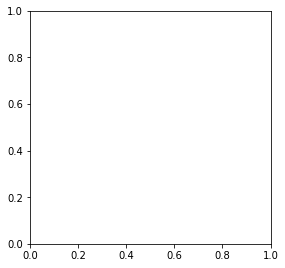

In [ ]:
test_output_list = sorted(glob('/content/yolov5/runs/detect/exp/*.png'))

plt.figure(figsize=(25,30))
for i in range(30):
    plt.subplot(6,5,i+1)
    # base64 형식을 array로 변환
    img = Image.open(BytesIO(test_output_list))
    img = np.array(img, np.uint8)
    title = []
    for shape in train_json_list[i]['shapes']:
        points = np.array(shape['points'], np.int32)
        cv2.polylines(img, [points], True, (0,255,0), 3)
        title.append(shape['label'])
    title = ','.join(title)
    plt.imshow(img)
    plt.subplot(6,5,i+1).set_title(title)
plt.show()